In [90]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import torch.distributions as dist
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from scipy.stats import multivariate_normal
import pandas as pd

In [91]:
force_cpu = True
if not force_cpu:
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print("Using device", device)


Using device cpu


In [113]:
class JointDataset(Dataset): 
    def __init__(self, x, joint_names):
        self.x = x
        self.joint_names = joint_names
        super().__init__()
    def __len__(self):
        return self.x.size(0)
    def __getitem__(self, idx):
        return self.x[idx]


def make_joint_dataset(device: torch.device):
    
    with open("data/unlabelled/camera/joints/front_sit_stand.csv") as f:
        data = pd.read_csv(f, header=0)
        data = data.rename(columns={"x-axis": "x", "y-axis": "y", "z-axis": "z", "joint_names": "joint_name"})
        print(data.head())
    
    # Get the unique joint names and frame IDs
    joint_names = data["joint_name"].unique()
    frame_ids = data["frame_id"].unique()
    
    # Create a multi-index using 'frame_id' and 'joint_names'
    data.set_index(['frame_id', 'joint_name'], inplace=True)
    
    # Sort the index to ensure the data is in the correct order
    data.sort_index(inplace=True)
    
    # Convert the DataFrame to a NumPy array and reshape it
    x = data[['x', 'y', 'z']].values.reshape((frame_ids.size, joint_names.size, 3))
        
    dataset = JointDataset(
        joint_names=np.sort(joint_names),
        x=torch.from_numpy(x.reshape(x.shape[0], -1)).float().to(device))
    return dataset

In [114]:
# Load the data
train_dataset = make_joint_dataset(device=device)

   frame_id  timestamp_usec     joint_name          x           y            z
0         0          268566         PELVIS -35.965904  121.446609  2231.891113
1         0          268566    SPINE_NAVEL -46.754833  -36.169590  2264.973877
2         0          268566    SPINE_CHEST -54.007175 -164.899796  2259.733398
3         0          268566           NECK -55.790428 -348.966309  2191.183594
4         0          268566  CLAVICLE_LEFT -25.078732 -319.862854  2204.463135


In [115]:
train_dataset.x[0].reshape(32, 3).cpu().numpy()

array([[ 142.20766  ,  522.14825  , 2098.596    ],
       [-160.67505  ,  542.2831   , 2075.3567   ],
       [ -25.078732 , -319.86285  , 2204.4631   ],
       [ -85.8965   , -317.9064   , 2202.3394   ],
       [  18.672644 , -468.6959   , 2136.2637   ],
       [-127.32989  , -453.0575   , 2105.0806   ],
       [ 146.30359  ,  -33.99539  , 2165.623    ],
       [-203.42929  ,  -23.675352 , 2150.4087   ],
       [  -7.2281733, -423.77747  , 2033.9568   ],
       [ -52.0062   , -413.8788   , 2022.3567   ],
       [ 164.7248   ,  686.3532   , 2063.1277   ],
       [-212.06987  ,  682.9324   , 2031.8286   ],
       [  65.83153  ,  200.97363  , 1876.0988   ],
       [ -77.20744  ,  190.38484  , 1876.1362   ],
       [ 120.02299  ,  139.68652  , 1929.6199   ],
       [ -60.212757 ,  120.30266  , 1939.6466   ],
       [ -55.919403 , -413.0576   , 2154.382    ],
       [  46.294876 ,  116.650375 , 2235.8672   ],
       [-110.14407  ,  125.77158  , 2228.3057   ],
       [ 100.85912  ,  241.478 

In [117]:
list(train_dataset.joint_names).index('PELVIS')

23

In [118]:
train_dataset.x[0].reshape(-1, 3).cpu().numpy()[23, :]

array([ -35.965904,  121.44661 , 2231.891   ], dtype=float32)

In [124]:
class VAE(nn.Module):

    def __init__(self, input_dim, z_dim):
        super().__init__()
        # Encoder ---------------------
        self.enc = nn.Sequential(
            nn.Linear(input_dim, 2**6),
            nn.ReLU(),
            nn.Linear(2**6, 2**5),
            nn.ReLU())
        self.mu = nn.Linear(2**5, z_dim)
        self.logvar = nn.Linear(2**5, z_dim)
        # Decoder ---------------------        
        self.dec = nn.Sequential(
            nn.Linear(z_dim, 2**5),
            nn.ReLU(),
            nn.Linear(2**5, 2**6),
            nn.ReLU(),
            nn.Linear(2**6, input_dim))

    def encode(self, x):
        x = self.enc(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        z = self.dec(z)
        x = torch.sigmoid(z)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [125]:
# Try the model out
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
ae = VAE(input_dim=train_dataset.x[0].size(0), z_dim=4).to(device)
for batch_idx, x, in enumerate(train_loader):
    mu = ae.mu(ae.enc(x))
    x_rec = ae.decode(mu)
    break

In [126]:
seed = 123
lr = 0.001
batch_size=64
n_epoch = 300
weight_reg_loss = 10e3
z_dim = 4
w_l_reg = 0.01

torch.manual_seed(seed)

vae = VAE(input_dim=train_dataset.x[0].size(0), z_dim=z_dim).to(device)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)

optimizer_vae = optim.Adam(vae.parameters(), lr=lr)

hist_loss = []

with tqdm(total=n_epoch, leave=True) as pbar:
    
    for epoch in range(n_epoch):
        
        vae_loss, reg_loss = 0, 0
                    
        for batch_idx, x, in enumerate(train_loader):

            optimizer_vae.zero_grad()

            recon_x, mu, logvar = vae(x)
            
            l_rec = F.mse_loss(recon_x, x)
            l_reg = - torch.mean(0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp(), dim=1), dim=0)
            loss = l_rec + w_l_reg * l_reg
            
            loss.backward()
            optimizer_vae.step()

        # if epoch > 0 and epoch % 50 == 0:
        hist_loss.append(loss.item())
        pbar.update()
        pbar.set_postfix(loss=f"{vae_loss:.8f}")

  0%|          | 0/300 [00:00<?, ?it/s]

In [127]:
def plot_skeleton_3d(joint_pos, joint_names):
    bone_list = [['SPINE_CHEST', 'SPINE_NAVEL'],
     ['SPINE_NAVEL', 'PELVIS'],
     ['SPINE_CHEST', 'NECK'],
     ['NECK', 'HEAD'],
     ['HEAD', 'NOSE'],
     ['SPINE_CHEST', 'CLAVICLE_LEFT'],
     ['CLAVICLE_LEFT', 'SHOULDER_LEFT'],
     ['SHOULDER_LEFT', 'ELBOW_LEFT'],
     ['ELBOW_LEFT', 'WRIST_LEFT'],
     ['WRIST_LEFT', 'HAND_LEFT'],
     ['HAND_LEFT', 'HANDTIP_LEFT'],
     ['WRIST_LEFT', 'THUMB_LEFT'],
     ['PELVIS', 'HIP_LEFT'],
     ['HIP_LEFT', 'KNEE_LEFT'],
     ['KNEE_LEFT', 'ANKLE_LEFT'],
     ['ANKLE_LEFT', 'FOOT_LEFT'],
     ['NOSE', 'EYE_LEFT'],
     ['EYE_LEFT', 'EAR_LEFT'],
     ['SPINE_CHEST', 'CLAVICLE_RIGHT'],
     ['CLAVICLE_RIGHT', 'SHOULDER_RIGHT'],
     ['SHOULDER_RIGHT', 'ELBOW_RIGHT'],
     ['ELBOW_RIGHT', 'WRIST_RIGHT'],
     ['WRIST_RIGHT', 'HAND_RIGHT'],
     ['HAND_RIGHT', 'HANDTIP_RIGHT'],
     ['WRIST_RIGHT', 'THUMB_RIGHT'],
     ['PELVIS', 'HIP_RIGHT'],
     ['HIP_RIGHT', 'KNEE_RIGHT'],
     ['KNEE_RIGHT', 'ANKLE_RIGHT'],
     ['ANKLE_RIGHT', 'FOOT_RIGHT'],
     ['NOSE', 'EYE_RIGHT'],
     ['EYE_RIGHT', 'EAR_RIGHT']]
    fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
    
    # Determine which coordinate goes to which axis in the figure
    x, z, y = range(3) 
    
    # Invert the z axis
    ax.invert_zaxis()
    
    joint_names = list(joint_names)

    for bone in bone_list:
        idx_joint_0 = joint_names.index(bone[0])
        idx_joint_1 = joint_names.index(bone[1])
        ax.plot([joint_pos[idx_joint_0][x], joint_pos[idx_joint_1][x]],
                [joint_pos[idx_joint_0][y], joint_pos[idx_joint_1][y]],
                [joint_pos[idx_joint_0][z], joint_pos[idx_joint_1][z]])

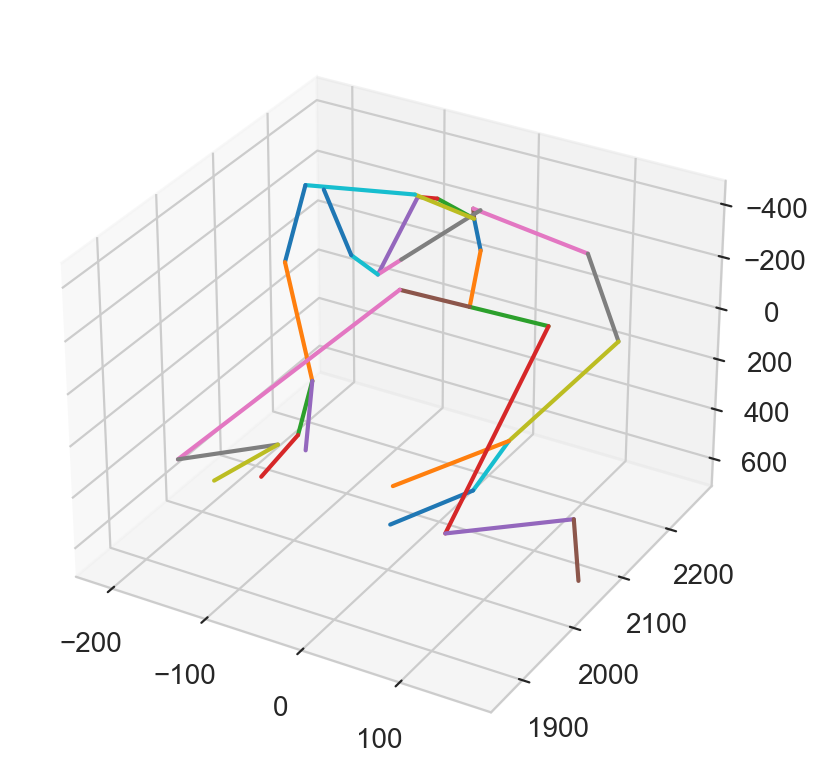

In [128]:
plot_skeleton_3d(train_dataset.x[2].reshape(32, 3).cpu().numpy(), train_dataset.joint_names)